# Model selection (I)

Adapted by Dick Furnstahl from Christian Forssen, TALENT Course 11, June, 2019.

### Bayesian evidence: 
Please see the Lecture 14 notes for a somewhat adapted version of Ch. 4.1 in Sivia's book: "The story of Dr A and Prof B". It also contains a summary of Laplace's method for approximating evidence factors.

### Import of modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import optimize

# Not really needed, but nicer plots
import seaborn as sns
sns.set()
sns.set_context("talk")

## What order polynomial?

Throughout the rest of this section, we will use data that was generated from a "true model" where x and y satisfy the following:

$$
y_i = x_i \sin(x_i)+\epsilon_i, 
$$

where $0 \leq x_i \leq 3$ and the noise is drawn from a normal distribution $\epsilon_i \sim \mathcal{N}(0, \sigma_0)$. The values for 20 regularly spaced points with $\sigma_0=0.1$ are shown below.

In [2]:
#------------------------------------------------------------
# Define our functional form
def true_func(x):
    return np.sin(x) * x

def func(x, dy=0.1):
    return np.random.normal(true_func(x), dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
num_data = 20
x_max = 3
x = np.linspace(0, x_max, num_data+2)[1:-1]
sig0 = 0.1  # try 0.5 or higher or 0.01
y = func(x, sig0)

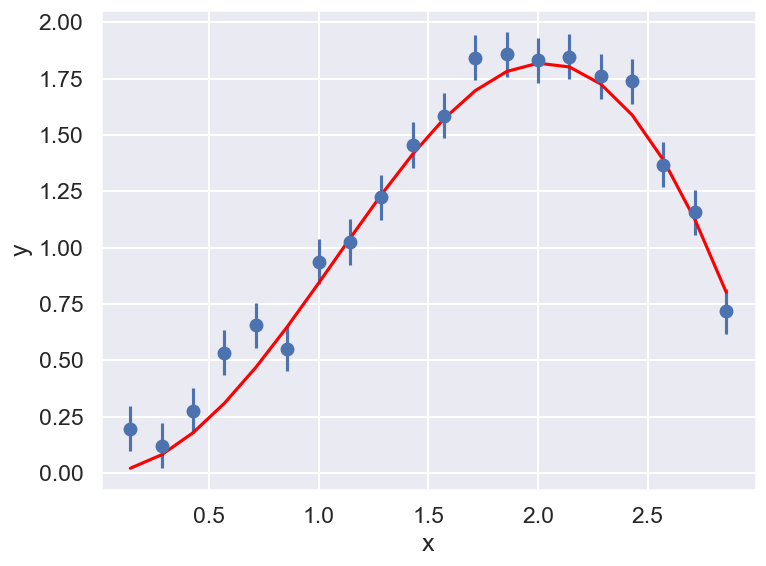

In [3]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, sig0, fmt='o');
ax.plot(x, true_func(x), color='red')
ax.set(xlabel='x',ylabel='y')
fig.tight_layout()

Assume that we have a multiple of models, with varying degree of sophistication. In this example we use polynomials of different orders to represent models of increasing complexity and with an increasing number of model parameters.

> Our task is to find which model finds the most support in the given data.

It is clear that a more complicated model with more free parameters should be able to fit the data much more closely. But what is the evidence in the data for such a complicated model? Finding the answer to this question is a task for a Bayesian, and the problem is generally known as *Model selection*. 

Below, we will use an approximate way of computing the Bayesian evidence, namely the Laplace method. In some cases one can also use conjugate priors to simplify the computation of the evidence factor. Or one can use certain sampling methods to compute the evidence numerically. The highlight will be the comparison of different models using the evidences to extract odds-ratios. 

### The Model

In general, we're fitting a $M$-degree polynomial to data, 

$$
y_M(x) = \sum_{i=0}^M \theta_i x^i
$$

where we use $\theta$ to denote our parameter vector of length $M$.

Assuming all the points are independent, we can find the full log likelihood by adding the individual likelihoods together:

$$
\begin{align}
\log p(D\mid\theta, I) &= -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\sigma_0^2) + \frac{\left[ y_i - y_M(x_i;\theta)\right]^2}{\sigma_0^2}\right) \\
&= \text{constant} - \sum_{i=1}^N \frac{\left[ y_i - y_M(x_i;\theta)\right]^2}{2 \sigma_0^2}
\end{align}
$$

We often define the residuals

$$
R_i = \left[ y_i - y_M(x_i;\theta) \right]/\sigma_0,
$$

so that the relevant chi-square sum reads $- \sum_{i=1}^N R_i^2 / 2$.

In [4]:
def residuals(theta, x=x, y=y, sigma0=sig0):
    dy = y - np.polyval(theta,x)
    return dy / sigma0

# Standard likelihood with Gaussian errors as specified
# uniform prior for theta
def log_likelihood(theta):
    return -0.5 * np.sum(residuals(theta)**2)

### Max likelihood fits

We can maximize the likelihood to find $\theta$ within a frequentist paradigm. Let us start with a linear fit:

In [5]:
degree = 1
theta_hat = np.polyfit(x, y, degree)
x_fit = np.linspace(0, x_max, 1000)
y_fit = np.polyval(theta_hat, x_fit)

Rather than just plotting this fit, we will compare several different models in the figure below.

degree  chi^2/dof


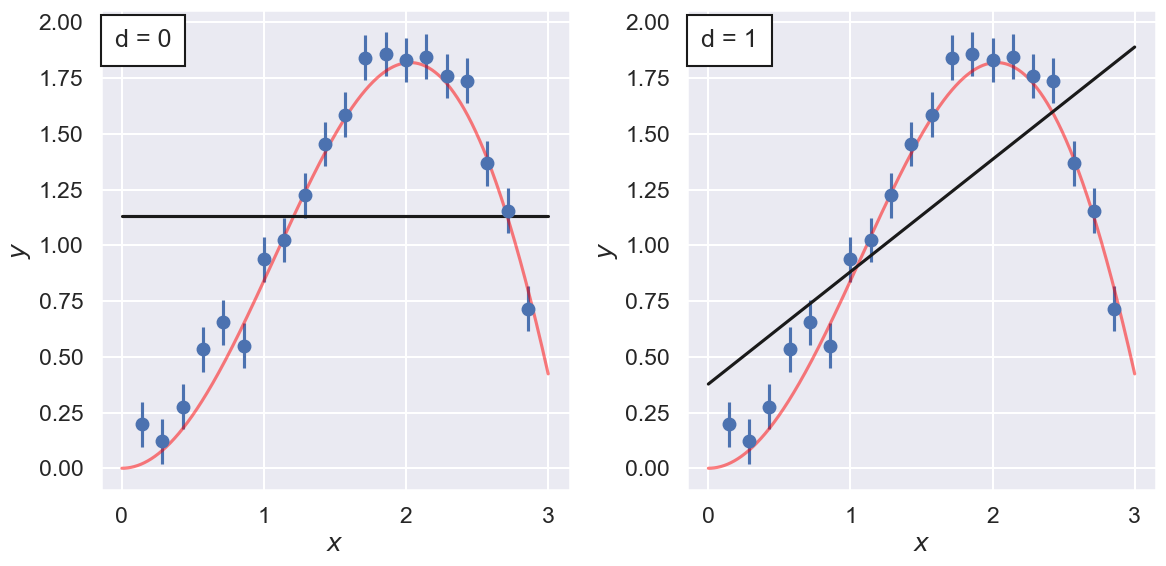

In [6]:
def fit_degree_n(degree, ax):
    """Fit a polynomial of order 'degree', return the chi-squared, and plot in axes 'ax'."""
    theta_hat = np.polyfit(x, y, degree)
    x_fit = np.linspace(0, x_max, 1000)
    y_fit = np.polyval(theta_hat, x_fit)
    
    ax.errorbar(x, y, sig0, fmt='o');
    ax.plot(x_fit, true_func(x_fit), color='red', alpha=.5)
    
    ax.text(0.03, 0.96, f"d = {degree}", transform=plt.gca().transAxes,
            ha='left', va='top',
            bbox=dict(ec='k', fc='w', pad=10))
    
    ax.plot(x_fit, y_fit, '-k')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$');
    
    return -2. * log_likelihood(theta_hat)  # chi_squared

#------------------------------------------------------------
# First figure: plot points with a linear fit
nrows=1; ncols=2;
fig = plt.figure(figsize=(6*ncols, 6*nrows))

num_plots = nrows * ncols
degrees = np.zeros(num_plots, dtype=int)
chi_sqs_dof = np.zeros(num_plots)
print('degree  chi^2/dof')
for i in range(num_plots):
    ax = fig.add_subplot(nrows, ncols, i+1)
    degrees[i] = i
    dof = len(x) - (degrees[i])
    chi_sqs_dof[i] = fit_degree_n(i, ax) / dof 
fig.tight_layout()

### Questions

* Change the degree of the polynomial that is used for the fit. Plot the fits next to each other in a multi-panel figure (e.g., make it 3 by 3).
* Compute the chi-squared value per degree of freedom (the ingredients are already included in the script) and plot that as a function of the degree of the polynomial. Is it decreasing, or is there a peak?
* For which degree polynomials would you say that you're underfitting the data?
* For which degree polynomials would you say that you're overfitting the data?


### Cross validation
This section will introduce the frequentist tool of cross-validation. This approach is used extensively within machine-learning as a way to handle overfitting and underfitting, bias and variance.

In [7]:
# Select the cross-validation points
ncross=5
index_cv = np.random.choice(range(len(x)), ncross, replace=False)

x_cv=x[index_cv]
y_cv=y[index_cv]

In [8]:
# The training data is then
x_train = np.delete(x,index_cv)
y_train = np.delete(y,index_cv)

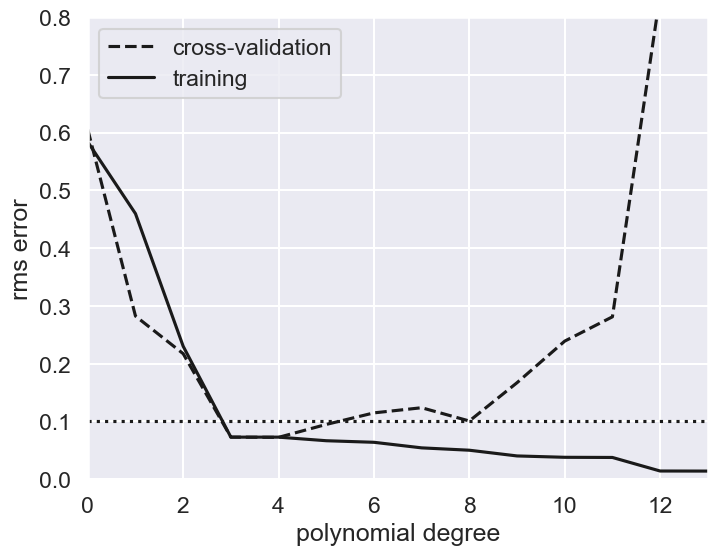

In [9]:
# Plot training and CV errors as a function of polynomial degree d
degree_max = 13
d = np.arange(0, degree_max+1)
training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

fig,ax = plt.subplots(figsize=(8, 6))
for i in range(len(d)):
    p = np.polyfit(x_train, y_train, d[i])
    training_err[i] = np.sqrt(np.sum((np.polyval(p, x_train) - y_train) ** 2)
                              / len(y_train))
    crossval_err[i] = np.sqrt(np.sum((np.polyval(p, x_cv) - y_cv) ** 2)
                              / len(y_cv))

ax.plot(d, crossval_err, '--k', label='cross-validation')
ax.plot(d, training_err, '-k', label='training')
ax.plot(d, sig0 * np.ones(d.shape), ':k')

ax.set_xlim(0, degree_max)
# You might need to change the y-scale if you make modifications to the training data
ax.set_ylim(0, 0.8)

ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend(loc='best');


### Questions

* Can you see the transition from underfit to overfit in this figure?
* What would you say is the degree of polynomial that is supported by the data?
* Try changing the size of the cross-validation and training sets. Does the conclusions become more/less clear?
* Does the results change between different runs with the same number of CV samples? If so, why?
* K-fold cross validation is a popular variant of CV. It addresses some issues with the sensitivity to the actual choice of which data is used for training and validation.  What do you think that it means, and what is the possible drawback if you have a computational expensive model?
* Leave-one-out is another variant. For linear regression problems, this type of cross-validation can actually be performed without having to do multiple fits. What do you think that it means?
* It is common to divide the data into a training set, a cross-validation set, and a test set. What do you think is the purpose of having three different sets?

## Bayesian evidence

Let us try the Bayesian approach and actually compute the evidence for these different models. We will use the Laplace method for computing the norm of the posterior distribution (i.e. approximating it as a single Gaussian).

We use simple uniform priors for the model parameters:

$$
p(\theta_i|I) = \left\{
\begin{array}{ll}
\frac{1}{\theta_\mathrm{max} - \theta_\mathrm{min}} & \text{for } \theta_\mathrm{min} \leq \theta_i \leq \theta_\mathrm{max}, \\
0 & \text{otherwise},
\end{array}
\right.
$$

which means that the posterior will be

$$
p(\theta | D, I) = \frac{1}{(\theta_\mathrm{max} - \theta_\mathrm{min})^K} \frac{1}{\sqrt{(2\pi)\sigma_0^2}^N} \exp\left( -\chi^2 / 2\right),
$$

within the allowed prior region for the $K$ parameters and zero elsewhere.

Assuming that the peak of the Gaussian is located at $\theta^*$, well inside the prior region; we can easily approximate the integral

$$
Z_p = \int d^K \theta p(\theta | D, I),
$$

using Laplace's method (see lecture notes here in [html](pub/model_selection-bs.html) and [pdf](pub/model_selection-minted.pdf) formats). With this particular choice of prior, and again under the assumption that the cut at the edges does not change the integral over the multidimensional integral, we get

$$
Z_p \approx \frac{1}{(\theta_\mathrm{max} - \theta_\mathrm{min})^K} \exp\left( -\chi^2(\theta^*) / 2\right) \frac{\sqrt{(2\pi)^K}}{\sqrt{\det(\Sigma^{-1})}},
$$

where $\Sigma^{-1}_{ij} = \partial^2\chi^2/\partial \theta_i \partial \theta_j$ (i.e. the Hessian) evaluated at the maximum $\theta^*$. Note that we removed the constant factor $\sqrt{(2\pi)\sigma_0}^N$ since it will be the same for all models. 

Note that for this linear regression problem we can get all these quantities ($\theta^*$, $\Sigma$) via linear algebra. Seethe lecture notes or Hogg's nice paper: [Data analysis recipes: Fitting a model to data](https://arxiv.org/abs/1008.4686). Below, we will use `numpy.polyfit` to extract the relevant quantities.

In [10]:
# We use a uniform prior for all parameters in [-10,10]
theta_max = 10
theta_min = -10
prior_range = theta_max - theta_min

In [11]:
degree_max = 6
evidence = np.zeros(degree_max+1)
print("Degree  P*          Best fit parameters: ")
for ideg,deg in enumerate(range(degree_max+1)):
    theta_hat, Cov = np.polyfit(x, y, deg,cov='unscaled')
    if not (np.all(theta_hat < theta_max) and np.all(theta_hat > theta_min)):
        print("Outside of prior range")
    P_star = np.exp(log_likelihood(theta_hat))
    H=np.linalg.inv(Cov)
    evidence[ideg] = P_star * np.sqrt((2*np.pi)**deg / np.linalg.det(H)) / prior_range**deg
    print (f'   {deg}    {P_star:.2e}  ',('{:5.2f} '*len(theta_hat)).format(*theta_hat))

Degree  P*          Best fit parameters: 
   0    1.76e-151    1.13 
   1    1.18e-76    0.50  0.38 
   2    2.69e-22   -0.59  2.26 -0.54 
   3    6.15e-03   -0.49  1.61 -0.44  0.21 
   4    6.44e-03   -0.02 -0.35  1.35 -0.25  0.18 
   5    7.62e-03    0.06 -0.48  0.88 -0.10  0.43  0.09 
   6    7.62e-03    0.00  0.03 -0.38  0.72  0.03  0.39  0.09 


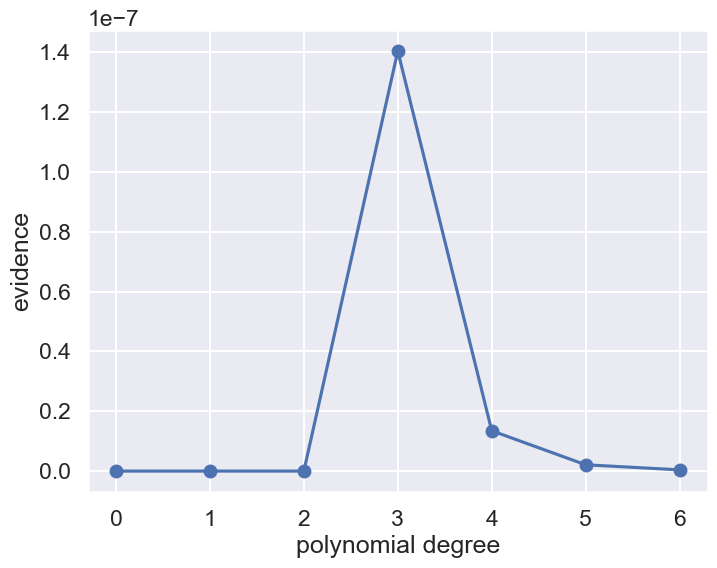

In [12]:
d = np.arange(0, degree_max+1)

fig,ax = plt.subplots(figsize=(8, 6))
ax.plot(d,evidence,'o-')

ax.set_xlabel('polynomial degree')
ax.set_ylabel('evidence');

### Questions

* Can you see the transition from underfit to overfit in this figure?
* What would you say is the degree of polynomial that is supported by the data?

In [13]:
# Odds ratio table




### Questions

* What happens when you change the number of the generated data?
* What happens when you change the range of the generated data?
* What happens when you change the error of the generated data?

#### Odds-ratios
Quoting the well-known paper by Trotta:
[Bayes in the sky: Bayesian inference and model selection in cosmology](https://arxiv.org/abs/0803.4089) we can quantify an empirical scale for evaluating the strength of evidence when comparing two models:
![Bayes in the Sky](https://raw.githubusercontent.com/buqeye/LearningFromData/main/LectureNotes/_images/trotta.png)

Here, the ratio of the evidences of model $M_0$ and $M_1$ is given by,

$$
 B_{01} = \frac{p(\mathrm{data} | M_0)}{p(\mathrm{data} | M_1)} \; ,
$$ 

which is also called _Bayes factor_. That means $|\ln B_{01}| \equiv |\ln p(\mathrm{data} | M_0) - \ln p(\mathrm{data} | M_1)|$ is the relevant quantity for estimating the strength of evidence of the two models (see first and last column of the table).

### Questions

* Create a table of odds-ratios to select between pairs of the different-order polynomial models, given that the ratio of prior probabilities for the different models is unity.